## read data

In [28]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt


In [2]:
cab= pd.read_csv("/mnt/batch/tasks/shared/LS_root/mounts/clusters/xiaoyanhouston1/code/Users/xiaoyanhouston/Cab_Data.csv" )
city= pd.read_csv("/mnt/batch/tasks/shared/LS_root/mounts/clusters/xiaoyanhouston1/code/Users/xiaoyanhouston/City.csv" )
customer_id = pd.read_csv("/mnt/batch/tasks/shared/LS_root/mounts/clusters/xiaoyanhouston1/code/Users/xiaoyanhouston/Customer_ID.csv" )
transaction_id =pd.read_csv("/mnt/batch/tasks/shared/LS_root/mounts/clusters/xiaoyanhouston1/code/Users/xiaoyanhouston/Transaction_ID.csv" )


In [3]:
cab= cab.rename(columns={'Transaction ID':'trans_id', 'Date of Travel':'trans_date','Company':'company','City':'city','KM Travelled':'km','Price Charged':'charge','Cost of Trip':'cost'})
cab.head()

,trans_id,trans_date,company,city,km,charge,cost
0,10000011,1/8/2016,Pink Cab,ATLANTA GA,30.45,370.95,313.635
1,10000012,1/6/2016,Pink Cab,ATLANTA GA,28.62,358.52,334.854
2,10000013,1/2/2016,Pink Cab,ATLANTA GA,9.04,125.20,97.632
3,10000014,1/7/2016,Pink Cab,ATLANTA GA,33.17,377.40,351.602
4,10000015,1/3/2016,Pink Cab,ATLANTA GA,8.73,114.62,97.776


In [4]:
city.head()

,City,Population,Users
0,NEW YORK NY,"8,405,837","302,149"
1,CHICAGO IL,"1,955,130","164,468"
2,LOS ANGELES CA,"1,595,037","144,132"
3,MIAMI FL,"1,339,155","17,675"
4,SILICON VALLEY,"1,177,609","27,247"


In [10]:
customer_id.head()

,Customer ID,Gender,Age,Income (USD/Month)
0,29290,Male,28,10813
1,27703,Male,27,9237
2,28712,Male,53,11242
3,28020,Male,23,23327
4,27182,Male,33,8536


In [11]:
transaction_id.head()

,Transaction ID,Customer ID,Payment_Mode
0,10000011,29290,Card
1,10000012,27703,Card
2,10000013,28712,Cash
3,10000014,28020,Cash
4,10000015,27182,Card


### 0. create tools 

In [5]:

def stat_cal(df,var,by=None):
    if by == None:
        df_stat =pd.DataFrame({
            'freq': df[var].count(),          # Count of non-null values
            'min': df[var].min(),             # Minimum value
            'mean': df[var].mean(),           # Mean
            'p1': df[var].quantile(0.01),     # 1st percentile
            'p10': df[var].quantile(0.1),     # 10th percentile
            'p25': df[var].quantile(0.25),    # 25th percentile
            'median': df[var].quantile(0.5),  # Median (50th percentile)
            'p75': df[var].quantile(0.75),    # 75th percentile
            'p90': df[var].quantile(0.9),     # 90th percentile
            'p99': df[var].quantile(0.99),    # 99th percentile
            'max': df[var].max()              # Maximum value
            }, index=[0])
    else:
        df_stat =df.groupby(by)[var].agg( [
                ('freq', 'count'),
                ('min', 'min'),
                ('mean','mean'),
                ('p1', lambda x: x.quantile(0.01)), 
                ('p10', lambda x: x.quantile(0.1)), 
                ('p25', lambda x: x.quantile(0.25)), 
                ('median', lambda x: x.quantile(0.5)), 
                ('p75', lambda x: x.quantile(0.75)), 
                ('p90', lambda x: x.quantile(0.9)),
                ('p99', lambda x: x.quantile(0.99)),
                ('max','max')
            ]).reset_index()

    return df_stat

### 1.explore cab data 

1.1 categorical variables analysis

In [12]:
cab.shape[0]

359392

In [13]:
cab['company'].value_counts()

company
Yellow Cab    274681
Pink Cab       84711
Name: count, dtype: int64

In [5]:
group_counts = cab.groupby(['city', 'company']).size().unstack(fill_value=0)
group_counts

company,Pink Cab,Yellow Cab
city,,
ATLANTA GA,1762,5795
AUSTIN TX,1868,3028
BOSTON MA,5186,24506
CHICAGO IL,9361,47264
DALLAS TX,1380,5637
DENVER CO,1394,2431
LOS ANGELES CA,19865,28168
MIAMI FL,2002,4452
NASHVILLE TN,1841,1169


### create new variables

In [5]:
cab2=cab.copy()

In [6]:
cab2['profit'] = cab2['charge'] -cab2['cost']
cab2['roi']= cab2['profit']/cab2['cost']
cab2['profit_km']= cab2['profit']/cab2['km']
cab2['charge_km'] = cab2['charge']/cab2['km']
cab2['cost_km'] = cab2['cost']/cab2['km']
# cab2['trans_month']=pd.to_datetime( cab2['trans_date']).dt.strftime('%Y-%m')
cab2['trans_month']=pd.to_datetime( cab2['trans_date']).dt.to_period('M').dt.to_timestamp()

In [12]:
cab2.head()

,trans_id,trans_date,company,city,km,charge,cost,profit,roi,profit_km,charge_km,cost_km,trans_month
0,10000011,1/8/2016,Pink Cab,ATLANTA GA,30.45,370.95,313.635,57.315,0.182744,1.882266,12.182266,10.3,2016-01-01
1,10000012,1/6/2016,Pink Cab,ATLANTA GA,28.62,358.52,334.854,23.666,0.070676,0.826904,12.526904,11.7,2016-01-01
2,10000013,1/2/2016,Pink Cab,ATLANTA GA,9.04,125.20,97.632,27.568,0.282366,3.049558,13.849558,10.8,2016-01-01
3,10000014,1/7/2016,Pink Cab,ATLANTA GA,33.17,377.40,351.602,25.798,0.073373,0.777751,11.377751,10.6,2016-01-01
4,10000015,1/3/2016,Pink Cab,ATLANTA GA,8.73,114.62,97.776,16.844,0.172271,1.929439,13.129439,11.2,2016-01-01


In [8]:
roi_mon_avg =cab2.groupby(['company','trans_month'])['roi'].agg('mean').reset_index()
roi_mon_avg               

,company,trans_month,roi
0,Pink Cab,2016-01-01,0.317165
1,Pink Cab,2016-02-01,0.342983
2,Pink Cab,2016-03-01,0.287291
3,Pink Cab,2016-04-01,0.281636
4,Pink Cab,2016-05-01,0.162339
...,...,...,...
67,Yellow Cab,2018-08-01,0.365628
68,Yellow Cab,2018-09-01,0.455942
69,Yellow Cab,2018-10-01,0.444251
70,Yellow Cab,2018-11-01,0.427768


In [9]:
roi_mon_avg.dtypes

company                object
trans_month    datetime64[ns]
roi                   float64
dtype: object

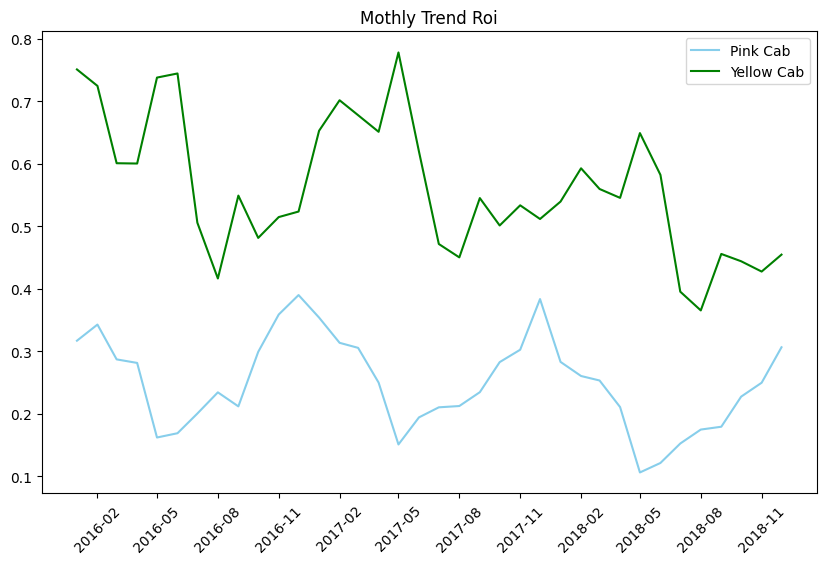

In [34]:
plt.figure(figsize=(10, 6))
plt.plot(roi_mon_avg[roi_mon_avg['company']=='Pink Cab']['trans_month'],roi_mon_avg[roi_mon_avg['company']=='Pink Cab']['roi'], color='skyblue', label='Pink Cab')
plt.plot(roi_mon_avg[roi_mon_avg['company']=='Yellow Cab']['trans_month'],roi_mon_avg[roi_mon_avg['company']=='Yellow Cab']['roi'], color='green', label='Yellow Cab')
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.MonthLocator(interval=3))
plt.xticks(rotation=45)
plt.legend()
plt.title('Mothly Trend Roi')
plt.show()

In [10]:
pkm_mon_avg =cab2.groupby(['company','trans_month'])['profit_km'].agg('mean').reset_index()
pkm_mon_avg               

,company,trans_month,profit_km
0,Pink Cab,2016-01-01,3.445081
1,Pink Cab,2016-02-01,3.722524
2,Pink Cab,2016-03-01,3.118522
3,Pink Cab,2016-04-01,3.045437
4,Pink Cab,2016-05-01,1.745338
...,...,...,...
67,Yellow Cab,2018-08-01,4.770231
68,Yellow Cab,2018-09-01,5.960597
69,Yellow Cab,2018-10-01,5.801843
70,Yellow Cab,2018-11-01,5.591507


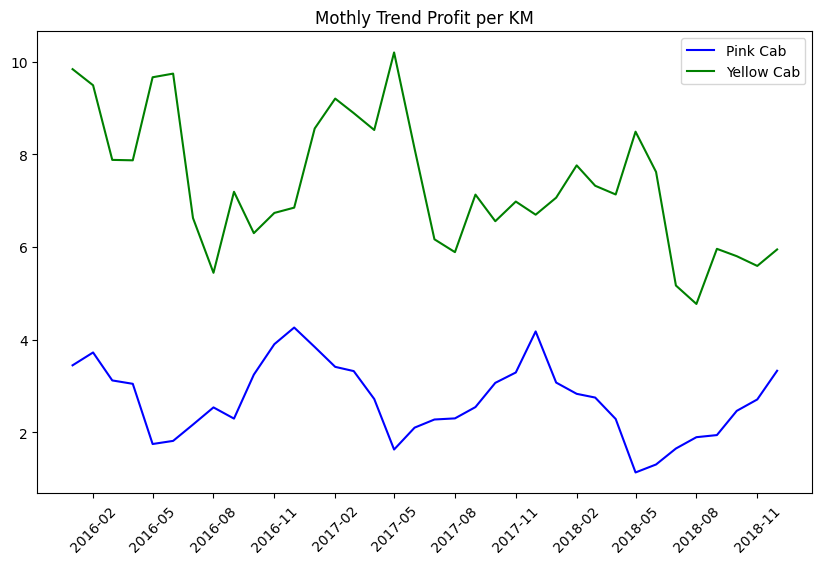

In [38]:
plt.figure(figsize=(10, 6))
plt.plot(pkm_mon_avg[pkm_mon_avg['company']=='Pink Cab']['trans_month'],pkm_mon_avg[pkm_mon_avg['company']=='Pink Cab']['profit_km'], color='blue', label='Pink Cab')
plt.plot(pkm_mon_avg[pkm_mon_avg['company']=='Yellow Cab']['trans_month'],pkm_mon_avg[pkm_mon_avg['company']=='Yellow Cab']['profit_km'], color='green', label='Yellow Cab')
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.MonthLocator(interval=3))
plt.xticks(rotation=45)
plt.legend()
plt.title('Mothly Trend Profit per KM')
plt.show()

Text(0.5, 1.0, 'Histogram of Pink Cab Charge per KM')

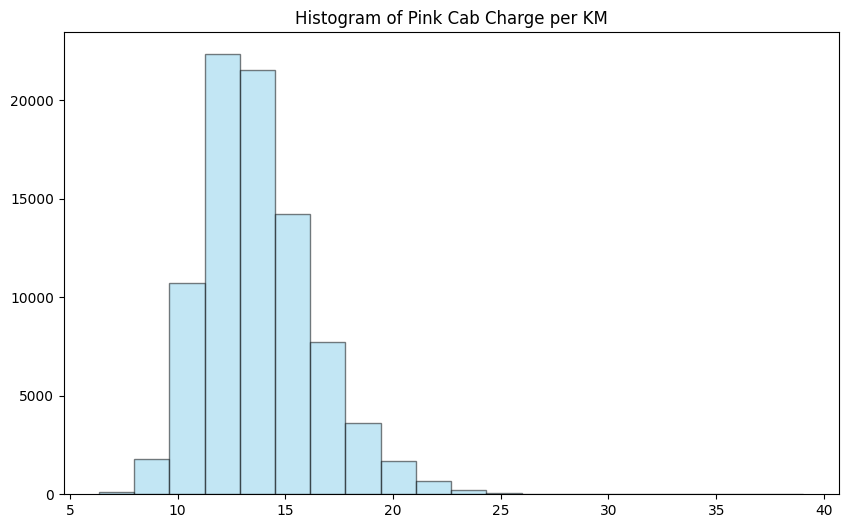

In [14]:
plt.figure(figsize=(10, 6))
plt.hist(cab2[cab2['company']=='Pink Cab']['charge_km'], bins=20, alpha=0.5, color='skyblue', edgecolor='black')
plt.title('Histogram of Pink Cab Charge per KM')

Text(0.5, 1.0, 'Histogram of Yellow Cab Charge per KM')

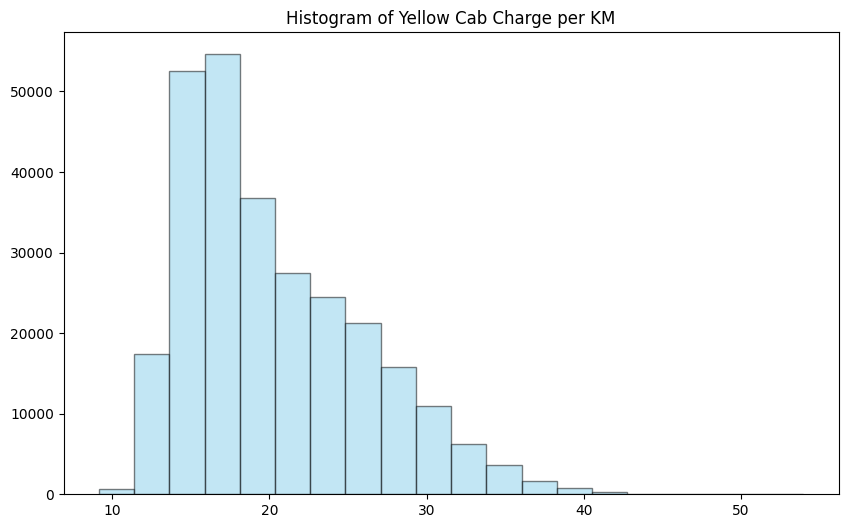

In [9]:
plt.figure(figsize=(10, 6))
plt.hist(cab2[cab2['company']=='Yellow Cab']['charge_km'], bins=20, alpha=0.5, color='skyblue', edgecolor='black')
plt.title('Histogram of Yellow Cab Charge per KM')

In [11]:
charge_km_stat= stat_cal(cab2,'charge_km',by='company')
charge_km_stat

,company,freq,min,mean,p1,p10,p25,median,p75,p90,p99,max
0,Pink Cab,84711,6.338621,13.768510,9.081306,10.814159,11.937046,13.396096,15.232716,17.200980,21.401440,39.046939
1,Yellow Cab,274681,9.161765,20.306073,12.166667,14.156532,15.805288,18.753655,24.100763,28.704678,36.194616,53.955556


In [12]:
cost_km_stat= stat_cal(cab2,'cost_km',by='company')
cost_km_stat

,company,freq,min,mean,p1,p10,p25,median,p75,p90,p99,max
0,Pink Cab,84711,10.0,10.998602,10.0,10.20,10.5,11.0,11.5,11.80,12.0,12.0
1,Yellow Cab,274681,12.0,13.200565,12.0,12.24,12.6,13.2,13.8,14.16,14.4,14.4


In [13]:
roi_stat= stat_cal(cab2,'roi',by='company')
roi_stat

,company,freq,min,mean,p1,p10,p25,median,p75,p90,p99,max
0,Pink Cab,84711,-0.409338,0.255596,-0.188659,-0.027195,0.080377,0.221544,0.394536,0.581485,0.982287,2.754513
1,Yellow Cab,274681,-0.352983,0.542966,-0.098961,0.063222,0.196803,0.428399,0.826903,1.187589,1.797403,3.202146


In [14]:
cab2[cab2['roi']<0].shape

(24819, 12)

In [14]:
cab2[cab2['roi']<0].head()

,trans_id,trans_date,company,city,km,charge,cost,profit,roi,profit_km,charge_km,cost_km,trans_month
53,10000064,1/6/2016,Pink Cab,DALLAS TX,9.45,73.43,98.280,-24.850,-0.252849,-2.629630,7.770370,10.4,2016-01-01
54,10000065,1/11/2016,Pink Cab,DALLAS TX,4.90,35.76,49.490,-13.730,-0.277430,-2.802041,7.297959,10.1,2016-01-01
55,10000066,1/2/2016,Pink Cab,DALLAS TX,13.13,122.42,149.682,-27.262,-0.182133,-2.076314,9.323686,11.4,2016-01-01
56,10000067,1/2/2016,Pink Cab,DALLAS TX,33.32,308.58,386.512,-77.932,-0.201629,-2.338896,9.261104,11.6,2016-01-01
57,10000068,1/11/2016,Pink Cab,DALLAS TX,4.52,38.31,52.884,-14.574,-0.275584,-3.224336,8.475664,11.7,2016-01-01


In [15]:
profit_km_stat= stat_cal(cab2,'profit_km',by='company')
profit_km_stat

,company,freq,min,mean,p1,p10,p25,median,p75,p90,p99,max
0,Pink Cab,84711,-4.912054,2.769908,-2.166489,-0.304830,0.891572,2.423598,4.281847,6.280322,10.474432,28.646939
1,Yellow Cab,274681,-4.998235,7.105508,-1.371847,0.845924,2.601667,5.601623,10.889670,15.539135,23.083729,41.115556


### assumption 2 The return of investment of Pink company and Yellow company are different

### Check cab VS city

In [16]:
cab_city=cab2[['company','city']].drop_duplicates()
cab_city.head()

,company,city
0,Pink Cab,ATLANTA GA
6,Pink Cab,AUSTIN TX
8,Pink Cab,BOSTON MA
23,Pink Cab,CHICAGO IL
53,Pink Cab,DALLAS TX


In [17]:
city = city.rename(columns={'City':'city'})
cab_city_pop=pd.merge(cab_city, city, on='city')
cab_city_pop.head()

,company,city,Population,Users
0,Pink Cab,ATLANTA GA,"814,885","24,701"
1,Yellow Cab,ATLANTA GA,"814,885","24,701"
2,Pink Cab,AUSTIN TX,"698,371","14,978"
3,Yellow Cab,AUSTIN TX,"698,371","14,978"
4,Pink Cab,BOSTON MA,"248,968","80,021"


In [18]:
Pink_cab_city=cab_city_pop[cab_city_pop['company']=='Pink Cab']
Yellow_cab_city=cab_city_pop[cab_city_pop['company']=='Yellow Cab']
Pink_Yellow_city= pd.merge(Pink_cab_city,Yellow_cab_city, on='city', how='outer')

In [16]:
Pink_Yellow_city.head()

,company_x,city,Population_x,Users_x,company_y,Population_y,Users_y
0,Pink Cab,ATLANTA GA,"814,885","24,701",Yellow Cab,"814,885","24,701"
1,Pink Cab,AUSTIN TX,"698,371","14,978",Yellow Cab,"698,371","14,978"
2,Pink Cab,BOSTON MA,"248,968","80,021",Yellow Cab,"248,968","80,021"
3,Pink Cab,CHICAGO IL,"1,955,130","164,468",Yellow Cab,"1,955,130","164,468"
4,Pink Cab,DALLAS TX,"942,908","22,157",Yellow Cab,"942,908","22,157"


In [19]:

columns_to_check = ['company_x', 'company_y']
filtered_df = Pink_Yellow_city[Pink_Yellow_city[columns_to_check].isnull().any(axis=1)]

In [20]:
filtered_df.head()


,company_x,city,Population_x,Users_x,company_y,Population_y,Users_y


In [10]:
customer_id = customer_id.rename(columns={'Customer ID':'customer_id', 'Gender':'gender','Age':'age','Income (USD/Month)':'income'})
transaction_id = transaction_id.rename(columns={'Transaction ID':'trans_id','Customer ID':'customer_id','Payment_Mode':'payment_model'})

In [40]:
customer_id.head()


,customer_id,gender,age,income
0,29290,Male,28,10813
1,27703,Male,27,9237
2,28712,Male,53,11242
3,28020,Male,23,23327
4,27182,Male,33,8536


In [13]:
transaction_customer= pd.merge(transaction_id, customer_id, on='customer_id', how ='inner' )
transaction_customer.head()

,trans_id,customer_id,payment_model,gender,age,income
0,10000011,29290,Card,Male,28,10813
1,10351127,29290,Cash,Male,28,10813
2,10412921,29290,Card,Male,28,10813
3,10000012,27703,Card,Male,27,9237
4,10320494,27703,Card,Male,27,9237


In [14]:
cab2_trans_customer=pd.merge(cab2, transaction_customer,on='trans_id',how='inner')
cab2_trans_customer.head()

,trans_id,trans_date,company,city,km,charge,cost,profit,roi,profit_km,charge_km,cost_km,trans_month,customer_id,payment_model,gender,age,income
0,10000011,1/8/2016,Pink Cab,ATLANTA GA,30.45,370.95,313.635,57.315,0.182744,1.882266,12.182266,10.3,2016-01-01,29290,Card,Male,28,10813
1,10000012,1/6/2016,Pink Cab,ATLANTA GA,28.62,358.52,334.854,23.666,0.070676,0.826904,12.526904,11.7,2016-01-01,27703,Card,Male,27,9237
2,10000013,1/2/2016,Pink Cab,ATLANTA GA,9.04,125.20,97.632,27.568,0.282366,3.049558,13.849558,10.8,2016-01-01,28712,Cash,Male,53,11242
3,10000014,1/7/2016,Pink Cab,ATLANTA GA,33.17,377.40,351.602,25.798,0.073373,0.777751,11.377751,10.6,2016-01-01,28020,Cash,Male,23,23327
4,10000015,1/3/2016,Pink Cab,ATLANTA GA,8.73,114.62,97.776,16.844,0.172271,1.929439,13.129439,11.2,2016-01-01,27182,Card,Male,33,8536


In [9]:
cab2_trans_customer.to_csv("/mnt/batch/tasks/shared/LS_root/mounts/clusters/xiaoyanhouston1/code/Users/xiaoyanhouston/cab2_trans_customer.csv")


NameError: name 'cab2_trans_customer' is not defined

In [15]:
cab2_trans_customer=pd.read_csv("/mnt/batch/tasks/shared/LS_root/mounts/clusters/xiaoyanhouston1/code/Users/xiaoyanhouston/cab2_trans_customer.csv")
cab2_trans_customer['trans_month']=pd.to_datetime( cab2_trans_customer['trans_month']).dt.to_period('M').dt.to_timestamp()

In [9]:
grouped = cab2_trans_customer.groupby(['trans_month', 'company'])
trans_count = grouped['trans_id'].count().reset_index().rename(columns={'trans_id':'trans_count'})

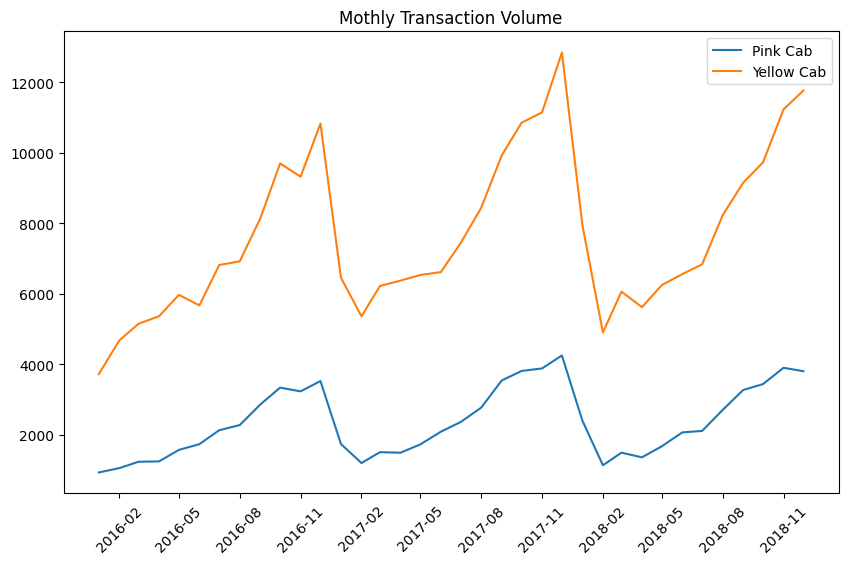

In [47]:
plt.figure(figsize=(10, 6))
Pink= trans_count[trans_count['company']=='Pink Cab']
Yellow = trans_count[trans_count['company']=='Yellow Cab']
plt.plot(Pink['trans_month'], Pink['trans_count'], label='Pink Cab')
plt.plot(Yellow['trans_month'], Yellow['trans_count'], label='Yellow Cab')
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.MonthLocator(interval=3))
plt.xticks(rotation=45)
plt.legend()
plt.title('Mothly Transaction Volume')
plt.show()

In [36]:
trans_count[trans_count['company']=='Pink Cab'].head()

,trans_month,company,trans_count
0,2016-01-01,Pink Cab,927
2,2016-02-01,Pink Cab,1050
4,2016-03-01,Pink Cab,1231
6,2016-04-01,Pink Cab,1240
8,2016-05-01,Pink Cab,1567


In [16]:
user_field= ['company','customer_id','age','gender','income']
user_data= cab2_trans_customer[user_field].drop_duplicates()
user_data.head()



,company,customer_id,age,gender,income
0,Pink Cab,29290,28,Male,10813
1,Pink Cab,27703,27,Male,9237
2,Pink Cab,28712,53,Male,11242
3,Pink Cab,28020,23,Male,23327
4,Pink Cab,27182,33,Male,8536


Text(0.5, 1.0, 'Histogram of Age from Yellow Cab')

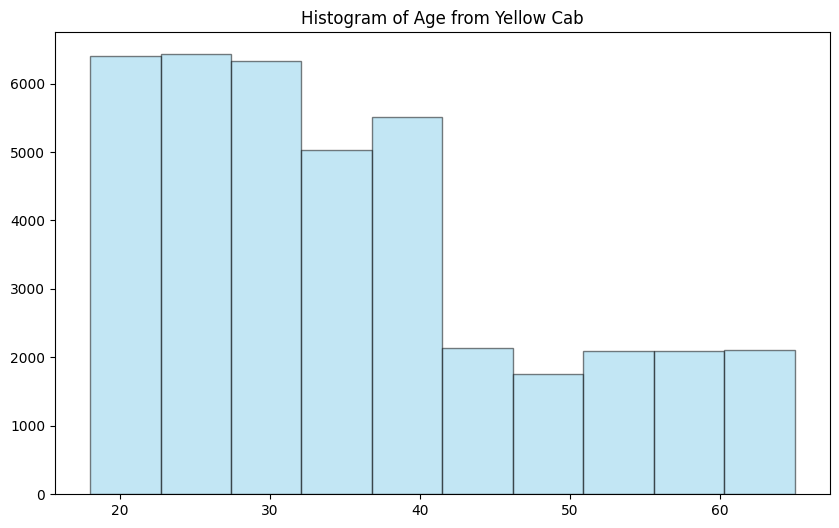

In [55]:
plt.figure(figsize=(10, 6))
plt.hist(user_data[user_data['company']=='Yellow Cab']['age'], bins=10, alpha=0.5, color='skyblue', edgecolor='black')
plt.title('Histogram of Age from Yellow Cab')

Text(0.5, 1.0, 'Histogram of Age from Pink Cab')

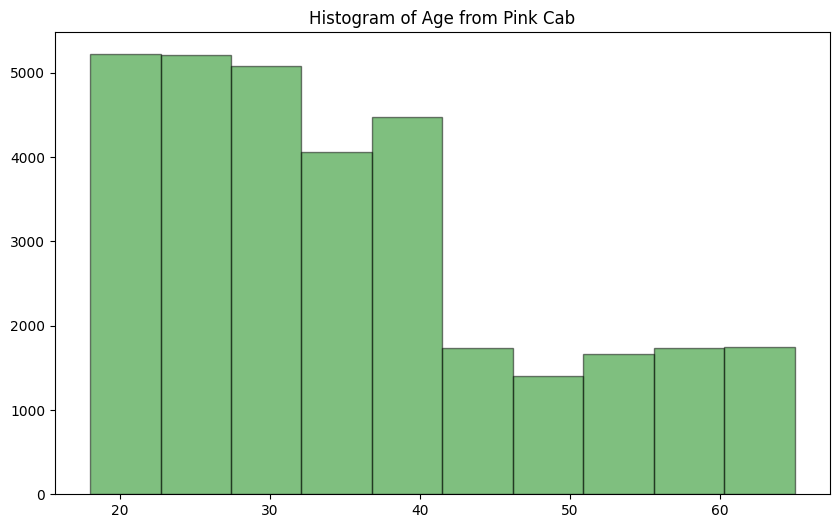

In [56]:
plt.figure(figsize=(10, 6))
plt.hist(user_data[user_data['company']=='Pink Cab']['age'], bins=10, alpha=0.5, color='green', edgecolor='black')
plt.title('Histogram of Age from Pink Cab')

In [57]:
user_sex_count= user_data.groupby(['company','gender'])['customer_id'].count().reset_index()
user_sex_count=user_sex_count.rename(columns={'customer_id':'count'})



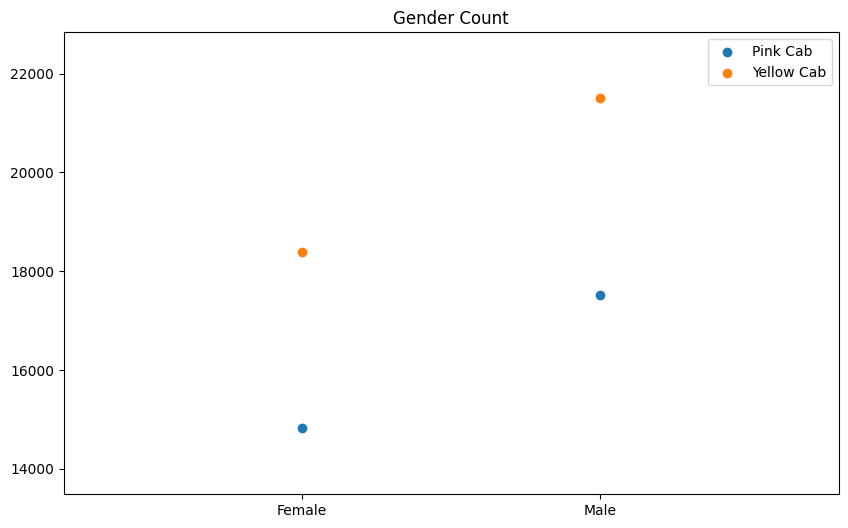

In [94]:
plt.figure(figsize=(10, 6))
Pink= user_sex_count[user_sex_count['company']=='Pink Cab']
Yellow = user_sex_count[user_sex_count['company']=='Yellow Cab']
plt.scatter(Pink['gender'], Pink['count'], label='Pink Cab')
plt.scatter(Yellow['gender'], Yellow['count'], label='Yellow Cab')
plt.legend()
plt.title('Gender Count')
# plt.margins(1)
plt.margins(x=0.8, y=0.2)
plt.show()

Text(0.5, 1.0, 'Histogram of income from Pink Cab')

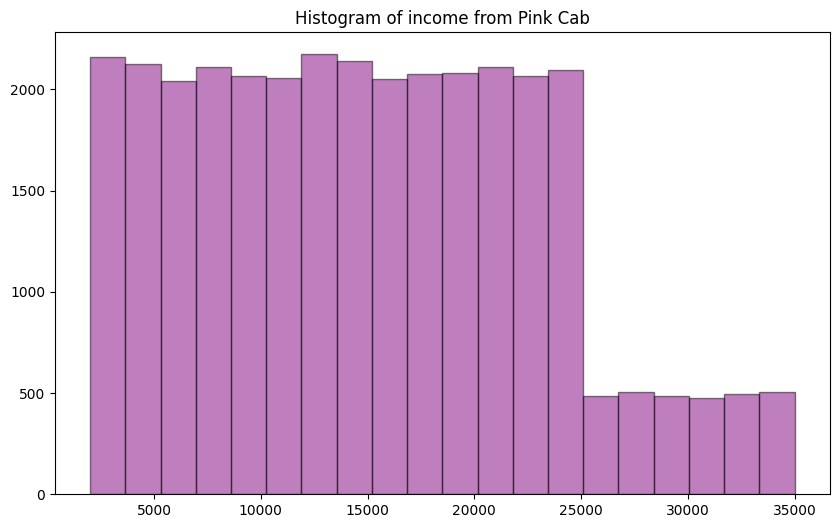

In [12]:
plt.figure(figsize=(10, 6))
plt.hist(user_data[user_data['company']=='Pink Cab']['income'], bins=20, alpha=0.5, color='purple', edgecolor='black')
plt.title('Histogram of income from Pink Cab')

Text(0.5, 1.0, 'Histogram of income from Yellow Cab')

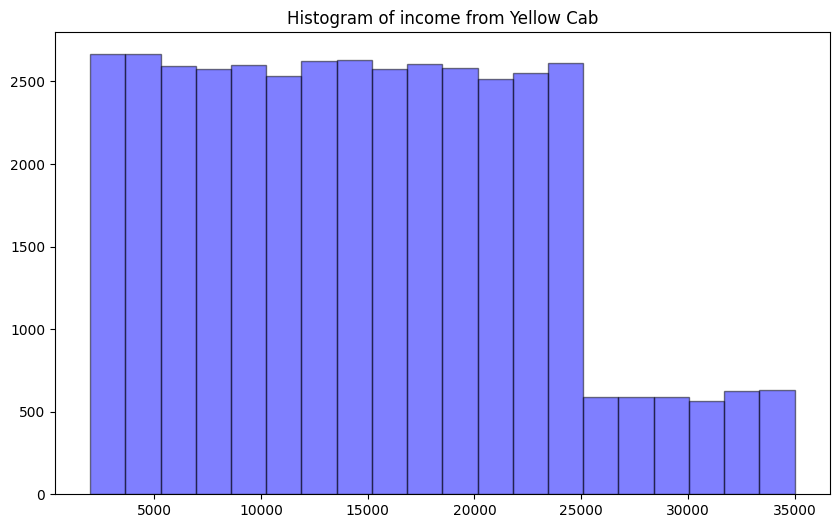

In [13]:
plt.figure(figsize=(10, 6))
plt.hist(user_data[user_data['company']=='Yellow Cab']['income'], bins=20, alpha=0.5, color='blue', edgecolor='black')
plt.title('Histogram of income from Yellow Cab')

Hypothesis Test

### assumption 1 The profit per kilometer of Pink company and Yellow company are the same

In [23]:
pink_sample= cab2_trans_customer[cab2_trans_customer['company']=='Pink Cab']['profit']
yellow_sample= cab2_trans_customer[cab2_trans_customer['company']=='Yellow Cab']['profit']

In [24]:
t_statistic, p_value = stats.ttest_ind(pink_sample, yellow_sample)
print("t-statistic:", t_statistic)
print("p-value:", p_value)
alpha = 0.05  # Significance level
if p_value < alpha:
    print("Reject the null hypothesis. The profit per kilometer of Pink company and Yellow company are different.")
else:
    print("Fail to reject the null hypothesis. There is no significant difference between the profit of Pink company and Yellow company.")

t-statistic: -160.3715175947806
p-value: 0.0
Reject the null hypothesis. The profit per kilometer of Pink company and Yellow company are different.


### assumption 2 The return of investment of Pink company is greater than Yellow company 

In [18]:
pink_sample= cab2_trans_customer[cab2_trans_customer['company']=='Pink Cab']['roi']
yellow_sample= cab2_trans_customer[cab2_trans_customer['company']=='Yellow Cab']['roi']

### 2 sample t-test

In [19]:
t_statistic, p_value = stats.ttest_ind(pink_sample, yellow_sample)

In [20]:
print("t-statistic:", t_statistic)
print("p-value:", p_value)

t-statistic: -179.2759885217892
p-value: 0.0


In [21]:
alpha = 0.05  # Significance level
if p_value < alpha:
    print("Reject the null hypothesis. The means of the two samples are significantly different.")
else:
    print("Fail to reject the null hypothesis. There is no significant difference between the means of the two samples.")

Reject the null hypothesis. The means of the two samples are significantly different.


In [22]:
t_statistic, p_value = stats.ttest_ind(pink_sample, yellow_sample, alternative='less')
print("t-statistic:", t_statistic)
print("p-value:", p_value)
alpha = 0.05  # Significance level
if p_value < alpha:
    print("Reject the null hypothesis. The mean of roi for Pink Cab is significantly smaller than the mean of roi for Yellow Cab.")
else:
    print("Fail to reject the null hypothesis. The mean of roi for Pink Cab is significantly greater than the mean of roi for Yellow Cab.")

t-statistic: -179.2759885217892
p-value: 0.0
Reject the null hypothesis. The mean of roi for Pink Cab is significantly smaller than the mean of roi for Yellow Cab.


### assumption3 The average age of customer from Pink company is the same as the customer from Yellow company

In [17]:

pink_sample= user_data[user_data['company']=='Pink Cab']['age']
yellow_sample = user_data[user_data['company']=='Yellow Cab']['age']


In [18]:
t_statistic, p_value = stats.ttest_ind(pink_sample, yellow_sample)
print("t-statistic:", t_statistic)
print("p-value:", p_value)
alpha = 0.05  # Significance level
if p_value < alpha:
    print("Reject the null hypothesis. The average age  of Pink company and Yellow company are different.")
else:
    print("Fail to reject the null hypothesis. There is no significant difference between the average age of Pink company and Yellow company.")

t-statistic: 0.31633759975120346
p-value: 0.7517471890396208
Fail to reject the null hypothesis. There is no significant difference between the average age of Pink company and Yellow company.


### assumption 4 The average income of customer from Pink company is the same as the customer from Yellow company

In [20]:
pink_sample= user_data[user_data['company']=='Pink Cab']['income']
yellow_sample = user_data[user_data['company']=='Yellow Cab']['income']


In [21]:
t_statistic, p_value = stats.ttest_ind(pink_sample, yellow_sample)
print("t-statistic:", t_statistic)
print("p-value:", p_value)
alpha = 0.05  # Significance level
if p_value < alpha:
    print("Reject the null hypothesis. The average income  of Pink company and Yellow company are different.")
else:
    print("Fail to reject the null hypothesis. There is no significant difference between the average income of Pink company and Yellow company.")

t-statistic: 0.838939895792237
p-value: 0.40150581507996785
Fail to reject the null hypothesis. There is no significant difference between the average income of Pink company and Yellow company.


### assumption 5 The gender distribution of customer from Pink company is the same as Yellow company

In [27]:
company_gender= user_data.groupby(['company','gender'])['customer_id'].count().reset_index()
company_gender= company_gender.rename(columns={'customer_id':'count'})
company_gender

,company,gender,count
0,Pink Cab,Female,14819
1,Pink Cab,Male,17511
2,Yellow Cab,Female,18394
3,Yellow Cab,Male,21502


In [31]:
company_gender= user_data.groupby(['company','gender'])['customer_id'].count()
company_gender

company     gender
Pink Cab    Female    14819
            Male      17511
Yellow Cab  Female    18394
            Male      21502
Name: customer_id, dtype: int64

In [33]:

company_gender_df = company_gender.unstack(fill_value=0)
array_2x2 = company_gender_df.to_numpy()
print(array_2x2)

[[14819 17511]
 [18394 21502]]


In [34]:
chi2_stat, p_val, dof, expected = chi2_contingency(array_2x2)

print("Chi-square statistic:", chi2_stat)
print("P-value:", p_val)
print("Degrees of freedom:", dof)
print("Expected frequencies:")
print(expected)

Chi-square statistic: 0.5063792600762221
P-value: 0.47671046144863083
Degrees of freedom: 1
Expected frequencies:
[[14866.89405477 17463.10594523]
 [18346.10594523 21549.89405477]]


Since the p-value (0.4767) is greater than the chosen significance level (commonly 0.05), we fail to reject the null hypothesis. This means that there is not enough evidence to conclude that there is a significant association between the gender of customers and the company they choose.